# ROCK PHYSICS MODELS AND TEMPLATES

This is an attempt to implement rock physics models and templates into an IPython/Jupyter notebook.

I will define here 5 functions to implement some of the easier (to code) rock physics models (RPM):

1. critical porosity (Nur et al., 1991, 1995);
2. Hertz-Mindlin, at the basis of soft and stiff sand models;
3. soft sand model (Dvorkin and Nur, 1996)
4. stiff sand model 
5. cemented sand model (or contact cement model; Dvorkin and Nur, 1996)
6. Vernik and Kachanov's models:  
    a) consolidated sand  
    b) soft sand 1  
    c) soft sand 2  
    d) sandstone diagenesis  
    e) shale  

For the first five, I followed the equations written on the Rock Physics handbook (Mavko, Mukerji and Dvorkin, 2009, 2nd edition), but I was also helped by reading the sections on rock physics models found on my worn-out copies of Quantitative Seismic Interpretation (Avseth, Mukerji and Mavko, 2005) and Seismic Reflections of Rock Properties (Dvorkin, Gutierrez and Grana, 2014).

The models introduced by Vernik and Kachanov in their 2010 papers have been a challenge to understand them first, then to code. The paper is brilliant, the whole approach is very practical, but whenever I'm faced with terms like micromechanics, non-interaction approximations etc I have to pause, take a deep breath, and jump over my abysmal pits of ignorance to try get the overall picture.

But I kinda *had* to do it, because Lev Vernik himself emailed me after my Seismic Rock Physics tutorial was [published on the Leading Edge](http://library.seg.org/doi/10.1190/tle36060523.1), lamenting the presence of only those models based on Hertz-Mindlin. I have then added an entire section to this notebook illustrating the way I understood these models, as an exercise for myself more than everything else. By the way, I am surprised these models do not appear to have been used much in recent publications; in my limited experience so far I have found them to be surprisingly useful, and I was very excited to find a good and reliable model for shales which I could use.

## setup python environment, load libraries

In [7]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
# comment out the following if you're not on a Mac with HiDPI display
%config InlineBackend.figure_format = 'retina'

## defining RPMs 1-5

In [8]:
def critpor(K0, G0, phi, phic=0.4):
    '''
    Critical porosity, Nur et al. (1991, 1995)
    written by aadm (2015) from Rock Physics Handbook, p.353

    INPUT
    K0, G0: mineral bulk & shear modulus in GPa
    phi: porosity
    phic: critical porosity (default 0.4)
    '''
    K_DRY  = K0 * (1-phi/phic)
    G_DRY  = G0 * (1-phi/phic)
    return K_DRY, G_DRY

def hertzmindlin(K0, G0, phi, phic=0.4, Cn=8.6, P=10, f=1):
    '''
    Hertz-Mindlin model
    written by aadm (2015) from Rock Physics Handbook, p.246

    INPUT
    K0, G0: mineral bulk & shear modulus in GPa
    phi: porosity
    phic: critical porosity (default 0.4)
    Cn: coordination nnumber (default 8.6)
    P: confining pressure in MPa (default 10)
    f: shear modulus correction factor
       1=dry pack with perfect adhesion
       0=dry frictionless pack
    '''
    P /= 1e3 # converts pressure in same units as solid moduli (GPa)
    PR0=(3*K0-2*G0)/(6*K0+2*G0) # poisson's ratio of mineral mixture
    K_HM = (P*(Cn**2*(1-phic)**2*G0**2) / (18*np.pi**2*(1-PR0)**2))**(1/3)
    G_HM = ((2+3*f-PR0*(1+3*f))/(5*(2-PR0))) * ((P*(3*Cn**2*(1-phic)**2*G0**2)/(2*np.pi**2*(1-PR0)**2)))**(1/3)
    return K_HM, G_HM

def softsand(K0, G0, phi, phic=0.4, Cn=8.6, P=10, f=1):
    '''
    Soft-sand (uncemented) model
    written by aadm (2015) from Rock Physics Handbook, p.258

    INPUT
    K0, G0: mineral bulk & shear modulus in GPa
    phi: porosity
    phic: critical porosity (default 0.4)
    Cn: coordination nnumber (default 8.6)
    P: confining pressure in MPa (default 10)
    f: shear modulus correction factor
       1=dry pack with perfect adhesion
       0=dry frictionless pack
    '''
    K_HM, G_HM = hertzmindlin(K0, G0, phi, phic, Cn, P, f)
    K_DRY =-4/3*G_HM + (((phi/phic)/(K_HM+4/3*G_HM)) + ((1-phi/phic)/(K0+4/3*G_HM)))**-1
    tmp = G_HM/6*((9*K_HM+8*G_HM) / (K_HM+2*G_HM))
    G_DRY = -tmp + ((phi/phic)/(G_HM+tmp) + ((1-phi/phic)/(G0+tmp)))**-1
    return K_DRY, G_DRY

def stiffsand(K0, G0, phi, phic=0.4, Cn=8.6, P=10, f=1):
    '''
    Stiff-sand model
    written by aadm (2015) from Rock Physics Handbook, p.260

    INPUT
    K0, G0: mineral bulk & shear modulus in GPa
    phi: porosity
    phic: critical porosity (default 0.4)
    Cn: coordination nnumber (default 8.6)
    P: confining pressure in MPa (default 10)
    f: shear modulus correction factor
       1=dry pack with perfect adhesion
       0=dry frictionless pack
    '''
    K_HM, G_HM = hertzmindlin(K0, G0, phi, phic, Cn, P, f)
    K_DRY = -4/3*G0 + (((phi/phic)/(K_HM+4/3*G0)) + ((1-phi/phic)/(K0+4/3*G0)))**-1
    tmp = G0/6*((9*K0+8*G0) / (K0+2*G0))
    G_DRY = -tmp + ((phi/phic)/(G_HM+tmp) + ((1-phi/phic)/(G0+tmp)))**-1
    return K_DRY, G_DRY

def contactcement(K0, G0, phi, phic=0.4, Cn=8.6, Kc=37, Gc=45, scheme=2):
    '''
    Contact cement (cemented sand) model, Dvorkin-Nur (1996)
    written by aadm (2015) from Rock Physics Handbook, p.255

    INPUT
    K0, G0: mineral bulk & shear modulus in GPa
    phi: porosity
    phic: critical porosity (default 0.4)
    Cn: coordination nnumber (default 8.6)
    Kc, Gc: cement bulk & shear modulus in GPa
            (default 37, 45 i.e. quartz)
    scheme: 1=cement deposited at grain contacts
            2=uniform layer around grains (default)
    '''
    PR0=(3*K0-2*G0)/(6*K0+2*G0)
    PRc = (3*Kc-2*Gc)/(6*Kc+2*Gc)
    if scheme == 1: # scheme 1: cement deposited at grain contacts
        alpha = ((phic-phi)/(3*Cn*(1-phic))) ** (1/4)
    else: # scheme 2: cement evenly deposited on grain surface
        alpha = ((2*(phic-phi))/(3*(1-phic)))**(1/2)
    LambdaN = (2*Gc*(1-PR0)*(1-PRc)) / (np.pi*G0*(1-2*PRc))
    N1 = -0.024153*LambdaN**-1.3646
    N2 = 0.20405*LambdaN**-0.89008
    N3 = 0.00024649*LambdaN**-1.9864
    Sn = N1*alpha**2 + N2*alpha + N3
    LambdaT = Gc/(np.pi*G0)
    T1 = -10**-2*(2.26*PR0**2+2.07*PR0+2.3)*LambdaT**(0.079*PR0**2+0.1754*PR0-1.342)
    T2 = (0.0573*PR0**2+0.0937*PR0+0.202)*LambdaT**(0.0274*PR0**2+0.0529*PR0-0.8765)
    T3 = 10**-4*(9.654*PR0**2+4.945*PR0+3.1)*LambdaT**(0.01867*PR0**2+0.4011*PR0-1.8186)
    St = T1*alpha**2 + T2*alpha + T3
    K_DRY = 1/6*Cn*(1-phic)*(Kc+(4/3)*Gc)*Sn
    G_DRY = 3/5*K_DRY+3/20*Cn*(1-phic)*Gc*St
    return K_DRY, G_DRY

## defining RPMs 6a-6e (Vernik & Kachanov 2010)

In [9]:
def vernik_csm(K0, G0, phi, sigma, b=10):
    '''
    vernik_csm (C) aadm 2017
    Vernik & Kachanov Consolidated Sand Model.

    reference:
    Vernik & Kachanov (2010), Modeling elastic properties of siliciclastic rocks, Geophysics v.75 n.6

    INPUT
    K0, G0: mineral bulk & shear modulus in GPa
    phi: porosity
    sigma: effective stress in MPa
    b: slope parameter in pore shape empirical equation (default 10, range 8-12)

    OUTPUT
    K_DRY, G_DRY: dry rock bulk & shear modulus in GPa
    '''
    # empirical pore shape factor
    p = 3.6+b*phi
    q = p # true if phi>0.03
    PSF = phi/(1-phi) # PSF = pore shape factor multiplier

    # matrix properties: assuming arenites w/ properties K=35.6 GPa, G=33 GPa, poisson's ratio nu_m = 0.146
    nu_m = 0.146
    Avm = (16*(1-nu_m**2) )/( 9*(1-2*nu_m))      # nu_m=0.146 --> Avm=2.46
    Bvm = (32*(1-nu_m)*(5-nu_m) )/( 45*(2-nu_m)) # nu_m=0.146 --> Bvm=1.59

    # crack density: inversely correlated to effective stress
    eta0 = 0.3+1.6*phi # crack density at zero stress
    d = 0.07 # compaction coefficient
    d = 0.02+0.003*sigma
    CD = (eta0 * np.exp(-d * sigma))/(1-phi)  # sigma=stress in MPa

    # note: the presence at denominator of the factor (1-phi) in PSF and CD is needed
    # to account for the interaction effects, i.e. the presence of pores raises the average stress
    # in the matrix increasing compliance contributions of pores and cracks
    # this correction is referred to as Mori-Tanaka's scheme.
    # in this way, the original model which is a NIA (non-interaction model)
    # is extended and becomes effectively a model which does take into account interactions.
    Kdry = K0*(1+p*PSF+Avm*CD)**-1
    Gdry = G0*(1+q*PSF+Bvm*CD)**-1
    return Kdry, Gdry


def vernik_ssm1(K0, G0, phi, sigma, phi_c=0.36, phi_con=0.26, b=10, n=2.00, m=2.05):
    '''
    vernik_ssm1 (C) aadm 2017
    Vernik & Kachanov Soft Sand Model 1.
    Only applicable for sands with porosity between phi_c and phi_con.

    reference:
    Vernik & Kachanov (2010), Modeling elastic properties of siliciclastic rocks, Geophysics v.75 n.6

    INPUT
    K0, G0: mineral bulk & shear modulus in GPa
    phi: porosity
    sigma: effective stress in MPa
    phi_c: critical porosity (default 0.36, range 0.30-0.42)
    phi_con: consolidation porosity (default 0.26, range 0.22-0.30)
    b: slope parameter in pore shape empirical equation (default 10, range 8-12)
    n, m: empirical factors (default 2.00, 2.05)

    OUTPUT
    K_DRY, G_DRY: dry rock bulk & shear modulus in GPa
    '''
    if isinstance(phi, np.ndarray):
        phi_edit = phi.copy()
        phi_edit[(phi_edit<phi_con) | (phi_edit>phi_c)]=np.nan
    else:
        phi_edit = np.array(phi)
        if (phi_edit<phi_con) | (phi_edit>phi_c):
            return np.nan, np.nan
    M0 = K0+4/3*G0
    K_con, G_con = vernik_csm(K0,G0,phi_con,sigma, b)
    M_con = K_con+4/3*G_con
    T = (1-(phi_edit-phi_con)/(phi_c-phi_con))
    Mdry = M_con*T**n
    Gdry = G_con*T**m
    Kdry = Mdry-4/3*Gdry
    return Kdry, Gdry


def vernik_ssm2(K0, G0, phi, p=20, q=20):
    '''
    vernik_ssm2 (C) aadm 2017
    Vernik & Kachanov Soft Sand Model 2.

    reference:
    Vernik & Kachanov (2010), Modeling elastic properties of siliciclastic rocks, Geophysics v.75 n.6

    INPUT
    K0, G0: mineral bulk & shear modulus in GPa
    phi: porosity
    p, q: pore shape factor for K and G (default p=q=20,range: 10-45)

    OUTPUT
    K_DRY, G_DRY: dry rock bulk & shear modulus in GPa
    '''
    M0 = K0+4/3*G0
    Mdry = M0*(1+p*(phi/(1-phi)))**-1
    Gdry = G0*(1+q*(phi/(1-phi)))**-1
    Kdry = Mdry-4/3*Gdry
    return Kdry, Gdry

def vernik_sdm(K0, G0, phi, sigma, phi_c=0.36, phi_con=0.26, b=10, n=2.00, m=2.05):
    '''
    vernik_sdm (C) aadm 2017
    Vernik & Kachanov Sandstone Diagenesis Model.
    Combination of CSM and SSM1 (for porosity>phi_con) models.

    reference:
    Vernik & Kachanov (2010), Modeling elastic properties of siliciclastic rocks, Geophysics v.75 n.6

    INPUT
    K0, G0: mineral bulk & shear modulus in GPa

    phi: porosity
    sigma: effective stress in MPa
    phi_c: critical porosity (default 0.36, range 0.30-0.42)
    phi_con: consolidation porosity (default 0.26, range 0.22-0.30)
    b: slope parameter in pore shape empirical equation (default 10, range 8-12)
    n, m: empirical factors (default 2.00, 2.05)

    OUTPUT
    K_DRY, G_DRY: dry rock bulk & shear modulus in GPa
    '''
    Kdry, Gdry = vernik_csm(K0, G0, phi, sigma, b)
    Kdry_soft, Gdry_soft = vernik_ssm1(K0, G0, phi, sigma, phi_c, phi_con, b, n, m)
    if isinstance(phi, np.ndarray):
        uu=phi>=phi_con
        Kdry[uu] = Kdry_soft[uu]
        Gdry[uu] = Gdry_soft[uu]
        return Kdry, Gdry
    else:
        if phi<=phi_con:
            return Kdry,Gdry
        else:
            return Kdry_soft, Gdry_soft

def vernik_shale(vclay, phi, rhom=2.73, rhob=1, Mqz=96, c33_clay=33.4, A=0.00284):
    '''
    vernik_shale (C) aadm 2017
    Vernik & Kachanov Shale Model.

    Shale matrix density (rhom) averages 2.73 +/- 0.03 g/cc at porosities below 0.25.
    It gradually varies with compaction and smectite-to-illite transition.
    A more accurate estimate can be calculated with this equation:
    rhom = 2.76+0.001*((rho-2)-230*np.exp(-4*(rho-2)))

    reference:
    Vernik & Kachanov (2010), Modeling elastic properties of siliciclastic rocks, Geophysics v.75 n.6

    INPUT
    vclay: dry clay content volume fraction
    phi: porosity (maximum 0.40)
    rhom: shale matrix density (g/cc, default 2.73)
    rhob: brine density (g/cc, default 1)
    Mqz: P-wave elastic modulus of remaining minerals (GPa, default 96)
    c33_clay: anisotropic clay constant (GPa, default 33.4)
    A: empirical coefficient for Vs (default .00284 for illite/smectite/chlorite,
       can be raised up to .006 for kaolinite-rich clays)

    OUTPUT
    vp, vs, density: P- and S-wave velocities in m/s, density in g/cc
    '''
    rho_matrix = 2.65*(1-vclay)+rhom*vclay
    k = 5.2-1.3*vclay
    B, C = 0.287, 0.79
    c33_min = (vclay/c33_clay + (1-vclay)/Mqz)**-1
    c33 = c33_min*(1-phi)**k
    vp = np.sqrt(c33/(rhom*(1-phi)+rhob*phi))
    vs = np.sqrt(A*vp**4 + B*vp**2 - C)
    rho = rho_matrix*(1-phi)+rhob*phi
    return vp*1e3,vs*1e3, rho

I need to define a couple more functions, one that implements Gassmann's equation to get the value of saturated bulk modulus and then calculate velocities, the second to calculate Voigt-Reuss-Hill bounds to get elastic moduli of mineral and fluid mixtures:

In [10]:
def vels(K_DRY,G_DRY,K0,D0,Kf,Df,phi):
    '''
    Calculates velocities and densities of saturated rock via Gassmann equation, (C) aadm 2015

    INPUT
    K_DRY,G_DRY: dry rock bulk & shear modulus in GPa
    K0, D0: mineral bulk modulus and density in GPa
    Kf, Df: fluid bulk modulus and density in GPa
    phi: porosity
    '''
    rho  = D0*(1-phi)+Df*phi
    K = K_DRY + (1-K_DRY/K0)**2 / ( (phi/Kf) + ((1-phi)/K0) - (K_DRY/K0**2) )
    vp   = np.sqrt((K+4./3*G_DRY)/rho)*1e3
    vs   = np.sqrt(G_DRY/rho)*1e3
    return vp, vs, rho, K

def vrh(volumes,k,mu):
    '''
    Calculates Voigt-Reuss-Hill bounds, (C) aadm 2015

    INPUT
    volumes: array with volumetric fractions
    k: array with bulk modulus
    mu: array with shear modulus

    OUTPUT
    k_u, k_l: upper (Voigt) and lower (Reuss) average of k
    mu_u, mu_l: upper (Voigt) and lower (Reuss) average of mu
    k0, mu0: Hill average of k and mu
    '''
    f=np.array(volumes).T
    k=np.resize(np.array(k),np.shape(f))
    mu=np.resize(np.array(mu),np.shape(f))
    ax=0 if f.ndim==1 else 1
    k_u = np.sum(f*k,axis=ax)
    k_l = 1./np.sum(f/k,axis=ax)
    mu_u = np.sum(f*mu,axis=ax)
    mu_l = 1./np.sum(f/mu,axis=ax)
    k0 = (k_u+k_l)/2.
    mu0 = (mu_u+mu_l)/2.
    return k_u, k_l, mu_u, mu_l, k0, mu0

_A little aside on the `vrh` function defined above; I use this and not `bruges.rockphysics.vrh` because I usually also need to compute Voigt and/or Reuss averages of mixtures (e.g., when mixing fluids using Reuss average, or to create a very stiff combination of minerals using Voigt average). My function also allows me to compute bulk and shear moduli averages all in one go instead of having to call a function twice, first to get K then G._

The following parameters are used to test these functions:

* `Dqz`, `Kqz`, `Gqz` are density, bulk and shear moduli for quartz
* `Dsh`, `Ksh`, `Gsh` are density, bulk and shear moduli for a generic shale
* `Kc`, `Gc` are bulk and shear moduli for cement (in this case I have assumed quartz cementation, but one can try also to use 21 and 7 for shale cement or 76.8 and 32 for calcite)
* `Db`, `Kb` are density and bulk modulus for brine
* `Do`, `Ko` are density and bulk modulus for oil
* `vsh` is the shale content (1-vsh is net:gross ratio)
* `Cn` is the coordination number, i.e the average number of contacts that each grain has with surrounding grains
* `phic` is the critical porosity, i.e. porosity of the sand when initially deposited, before diagenesis begins
* `f` is the shear modulus correction factor (f=1 for dry pack with perfect adhesion between particles and f=0 for a dry frictionless pack)
* `phi` is the actual porosity of our rock

In [11]:
Dqz, Kqz, Gqz = 2.65, 36.6, 45
Dsh, Ksh, Gsh = 2.7, 21, 7
Kc, Gc = 36.6, 45
Db, Kb = 1, 2.2
Do, Ko = 0.8, 1.5
Dg, Kg = 0.2, 0.06
vsh = 0.2
Cn = 6
phic = 0.40
f = 1
phi = 0.3

The following lines create a summary overview of P- and S-wave velocities behaviour against porosity for the four models:

Mineral matrix elastic moduli:
shale fraction=0.00, K=36.60     GPa, G=45.00 GPa, rho=2.65 g/cc


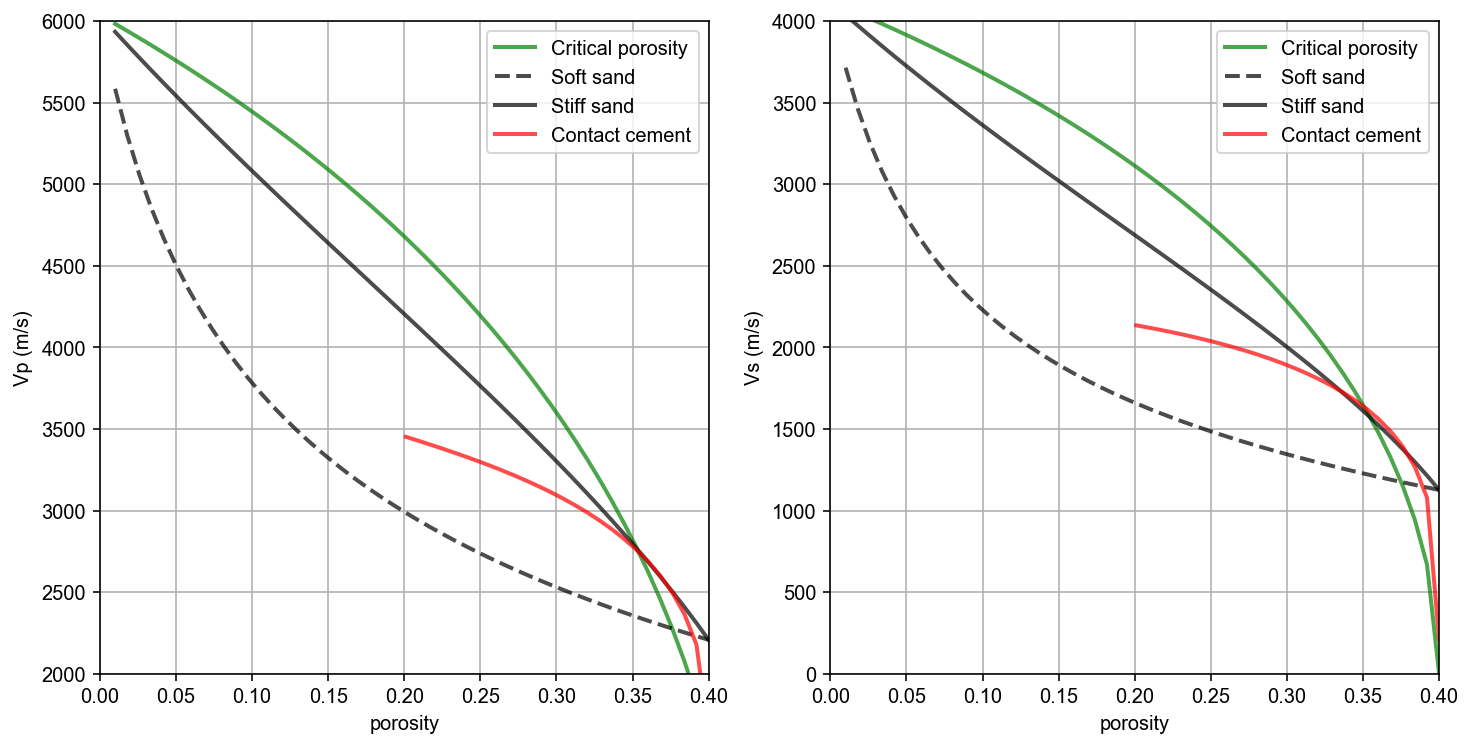

In [12]:
phi=np.linspace(0.01,0.40,50)
vsh=0.0

_,_,_,_,K0,G0 = vrh([vsh, 1-vsh],[Ksh,Kqz],[Gsh,Gqz])
D0=vsh*Dsh+(1-vsh)*Dqz

print('Mineral matrix elastic moduli:')
print('shale fraction={:.2f}, K={:.2f} \
    GPa, G={:.2f} GPa, rho={:.2f} g/cc'\
      .format(vsh, K0, G0, D0))
Kdry, Gdry = critpor(K0, G0, phi, phic)
vp_cri,vs_cri,_,_= vels(Kdry,Gdry,K0,D0,Kb,Db,phi)

Kdry, Gdry = softsand(K0, G0, phi, phic, Cn, P=30)
vp_ssm,vs_ssm,_,_= vels(Kdry,Gdry,K0,D0,Kb,Db,phi)

Kdry, Gdry = stiffsand(K0, G0, phi, phic, Cn, P=30)
vp_sti,vs_sti,_,_= vels(Kdry,Gdry,K0,D0,Kb,Db,phi)

Kdry, Gdry = contactcement(K0, G0, phi, phic, Cn, Kc, Gc)
vp_ccm,vs_ccm,_,_= vels(Kdry,Gdry,K0,D0,Kb,Db,phi)
vp_ccm[phi<0.2]=np.NaN
vs_ccm[phi<0.2]=np.NaN

f, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].plot(phi,vp_cri,'-g', lw=2, alpha=0.7, label='Critical porosity')
ax[0].plot(phi,vp_ssm,'--k', lw=2, alpha=0.7, label='Soft sand')
ax[0].plot(phi,vp_sti,'-k', lw=2, alpha=0.7, label='Stiff sand')
ax[0].plot(phi,vp_ccm,'-r', lw=2, alpha=0.7, label='Contact cement')
ax[1].plot(phi,vs_cri,'-g', lw=2, alpha=0.7, label='Critical porosity')
ax[1].plot(phi,vs_ssm,'--k', lw=2, alpha=0.7, label='Soft sand')
ax[1].plot(phi,vs_sti,'-k', lw=2, alpha=0.7, label='Stiff sand')
ax[1].plot(phi,vs_ccm,'-r', lw=2, alpha=0.7, label='Contact cement')
ax[0].set_ylim(2000,6000)
ax[0].set_ylabel('Vp (m/s)')
ax[1].set_ylim(0,4000)
ax[1].set_ylabel('Vs (m/s)')
for aa in ax:
    aa.set_xlim(0,0.4)
    aa.grid()
    aa.legend()
    aa.set_xlabel('porosity')

### a short detour on Vernik & Kachanov's models

Short detour here.

## rock physics templates (RPT)

All the models can be used to calculate elastic properties with various combination of lithology and fluid parameters. Avseth first introduced the concept of _rock physics templates_ (RPT) to display a reference framework of all the possible variations of a particular rock and use such templates to understand actual well log data (or seismic-derived elastic properties).

I always liked the look of these templates probably because when I first approached quantitative interpretation I immediately got stuck with the horrible Hampson-Russell crossplots and their ugly green grids and the splotches of colored polygons to mark "shaly sands", "silty sand" and other useless definitions.

What follows is a Pythonic way to do RPT; please note that the interactive templates need to be run locally, so download the notebook on you computer first, make sure you have a working Python/Jupyter system and enjoy.

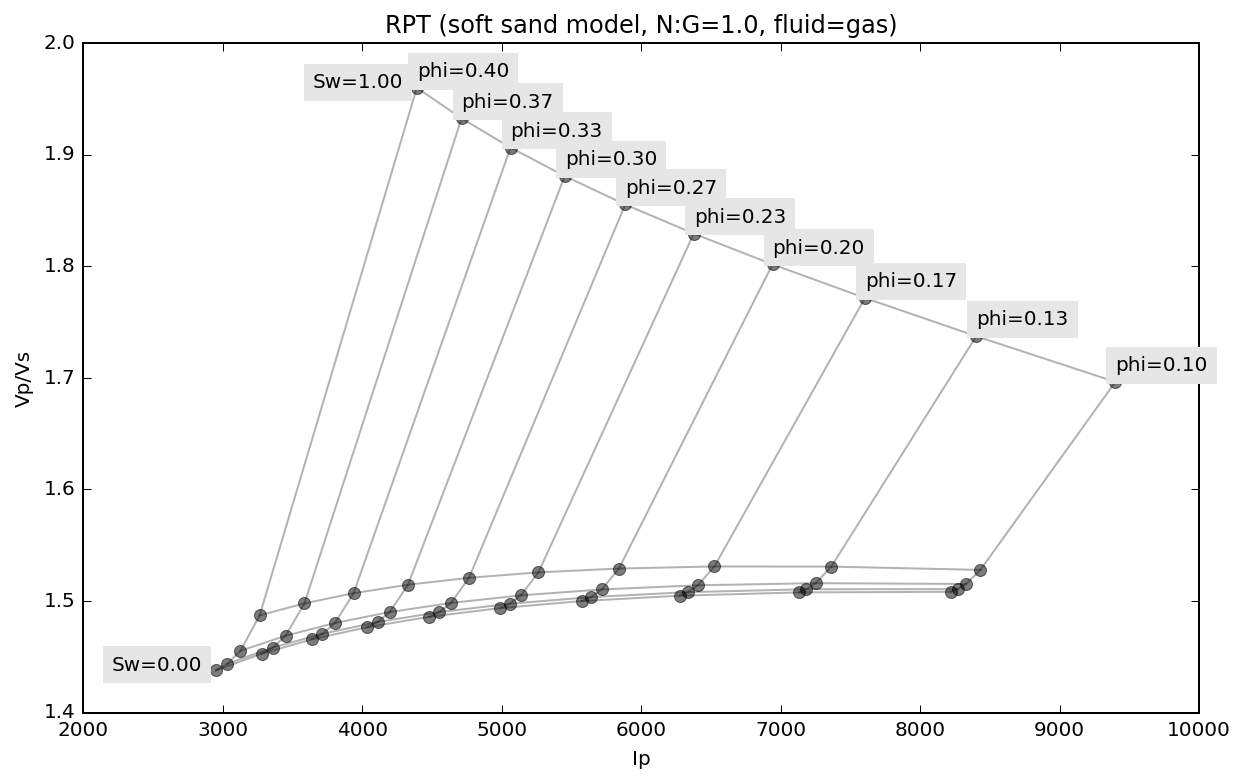

In [6]:
phi=np.linspace(0.10,0.40,10)
sw=np.linspace(0,1,5)
vsh=0.0
fluid='gas'

# elastic moduli of rock matrix
K0,G0 = vrh([vsh, 1-vsh],[Ksh,Kqz],[Gsh,Gqz])[4:]
D0 = vsh*Dsh+(1-vsh)*Dqz

# elastic moduli of dry-rock frame (does not depend on fluid)
Kdry, Gdry = softsand(K0, G0, phi, phic, Cn, P=30)

# setup empty arrays to store Ip and Vp/Vs values
xx=np.empty((phi.size,sw.size))
yy=np.empty((phi.size,sw.size))

# loop over Sw, computes elastic moduli of fluid mixture
# and saturated rock properties with Gassmann's equation
(Khc, Dhc) = (Kg, Dg) if fluid == 'gas' else (Ko,Do)
for i,val in enumerate(sw):
    Kf = vrh([val,1-val],[Kb,Khc],[999,999])[1]
    Df = val*Db+(1-val)*Dhc
    vp,vs,rho,_= vels(Kdry,Gdry,K0,D0,Kf,Df,phi)
    xx[:,i]=vp*rho
    yy[:,i]=vp/vs
    
plt.figure(figsize=(10,6))
plt.plot(xx, yy, '-ok', alpha=0.3)
plt.plot(xx.T, yy.T, '-ok', alpha=0.3)
for i,val in enumerate(phi):
    plt.text(xx[i,-1],yy[i,-1]+.01,'phi={:.02f}'.format(val), backgroundcolor='0.9')
plt.text(xx[-1,0]-100,yy[-1,0],'Sw={:.02f}'.format(sw[0]),ha='right', backgroundcolor='0.9')
plt.text(xx[-1,-1]-100,yy[-1,-1],'Sw={:.02f}'.format(sw[-1]),ha='right', backgroundcolor='0.9')
plt.xlabel('Ip'), plt.ylabel('Vp/Vs')
plt.title('RPT (soft sand model, N:G={0}, fluid={1})'.format(1-vsh, fluid))

Let's put it all in a function and then make it interactive:

In [7]:
def rpt(model='soft',vsh=0.0,fluid='gas',phic=0.4,Cn=8,P=10,f=1,cement='quartz'):
    if cement=='quartz':
        Kc, Gc = 37, 45
    elif cement=='calcite':
        Kc, Gc = 76.8, 32
    elif cement=='clay':
        Kc, Gc = 21, 7
    phi=np.linspace(0.1,phic-.1,6)
    sw=np.linspace(0,1,5)
    (Khc, Dhc) = (Kg, Dg) if fluid == 'gas' else (Ko,Do)
    K0,G0 = vrh([vsh, 1-vsh],[Ksh,Kqz],[Gsh,Gqz])[4:]
    D0 = vsh*Dsh+(1-vsh)*Dqz
    if model=='soft':
        Kdry, Gdry = softsand(K0,G0,phi,phic,Cn,P,f)
    elif model=='stiff':
         Kdry, Gdry = stiffsand(K0,G0,phi,phic,Cn,P,f)
    elif model=='cem':
         Kdry, Gdry = contactcement(K0,G0,phi,phic,Cn,Kc,Gc,scheme=2)
    elif model=='crit':
         Kdry, Gdry = critpor(K0,G0,phi,phic)
            
    xx=np.empty((phi.size,sw.size))
    yy=np.empty((phi.size,sw.size))

    for i,val in enumerate(sw):
        Kf = vrh([val,1-val],[Kb,Khc],[999,999])[1]
        Df = val*Db+(1-val)*Dhc
        vp,vs,rho,_= vels(Kdry,Gdry,K0,D0,Kf,Df,phi)
        xx[:,i]=vp*rho
        yy[:,i]=vp/vs

    opt1={'backgroundcolor':'0.9'}
    opt2={'ha':'right','backgroundcolor':'0.9'}
    plt.figure(figsize=(10,6))
    plt.plot(xx, yy, '-ok', alpha=0.3)
    plt.plot(xx.T, yy.T, '-ok', alpha=0.3)
    for i,val in enumerate(phi):
        plt.text(xx[i,-1],yy[i,-1]+.01,'$\phi={:.02f}$'.format(val), **opt1)
    plt.text(xx[-1,0]-100,yy[-1,0],'$S_w={:.02f}$'.format(sw[0]), **opt2)
    plt.text(xx[-1,-1]-100,yy[-1,-1],'$S_w={:.02f}$'.format(sw[-1]), **opt2)
    plt.xlabel('Ip'), plt.ylabel('Vp/Vs')
    plt.xlim(xx.min()-xx.min()*.1,xx.max()+xx.max()*.1)
    plt.ylim(yy.min()-yy.min()*.1,yy.max()+yy.max()*.1)
    plt.title('RPT (N:G={0}, fluid={1})'.format(1-vsh, fluid))

<function __main__.rpt>

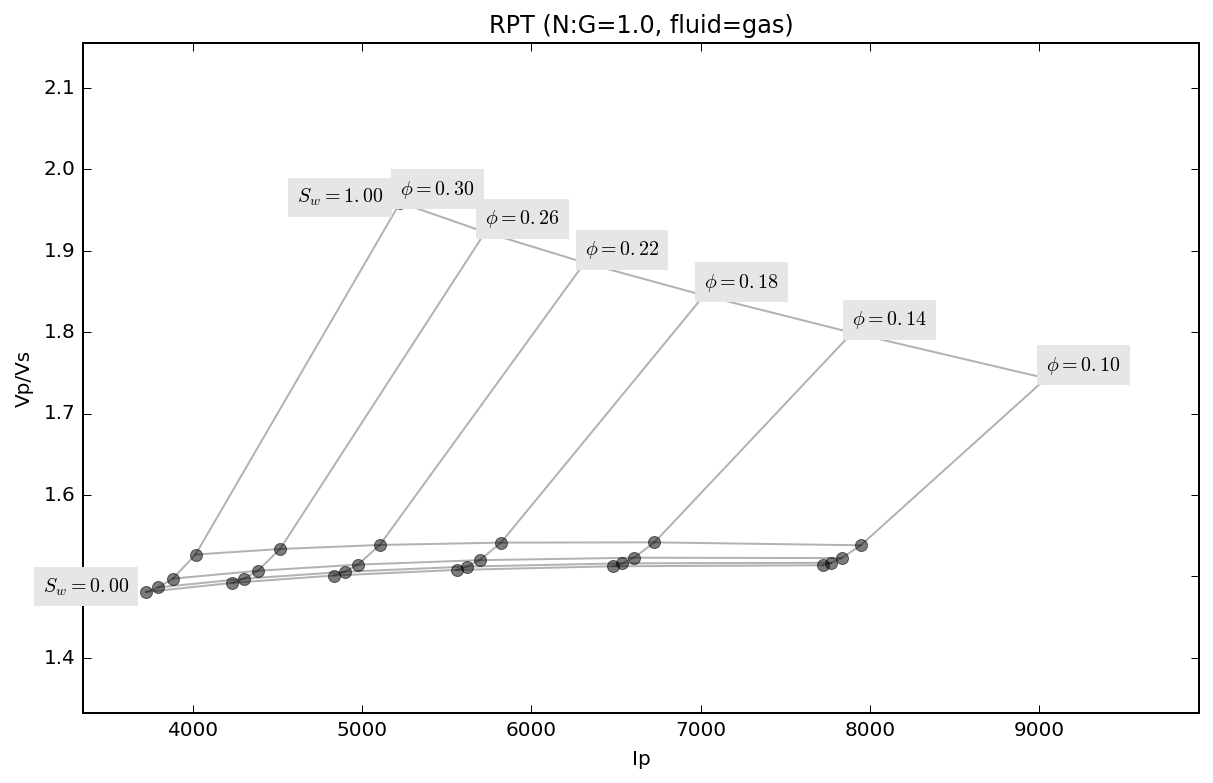

In [8]:
from ipywidgets import interact, ToggleButtons, RadioButtons, HTML
rpm_buttons = ToggleButtons(description='RPM',options=['soft','stiff','cem','crit'])
fluid_buttons = ToggleButtons(description='Fluid',options=['gas','oil'])
cement_buttons = ToggleButtons(description='Cement',options=['quartz','clay','calcite'])
interact(rpt,
         model=rpm_buttons, fluid=fluid_buttons,
         vsh=(0,1,.1),phic=(.2,0.4,.01),Cn=(1,20),P=(1,100),f=(0,1,.1),
         cement=cement_buttons)

## RPT and well log data

Obviously the real power of a template like the one above is to use it to understand real data.

The following is a (static) example using well logs that I have [previously used](http://nbviewer.ipython.org/github/aadm/geophysical_notes/blob/master/seismic_petrophysics.ipynb).

The idea is to use widgets also here so that the user can play with parameters and define the optimal modeling very quickly; unfortunately I had not find a solution to do that, yet.

In [9]:
data=np.genfromtxt('qsiwell2.csv',delimiter=',',names=True)

sel=(data['DEPTH']>=2014) & (data['DEPTH']<=2600)
ww=np.empty((data['DEPTH'][sel].size,3))
ww[:,0]=data['IP'][sel]
ww[:,1]=data['VPVS'][sel]
ww[:,2]=data['VSH'][sel]

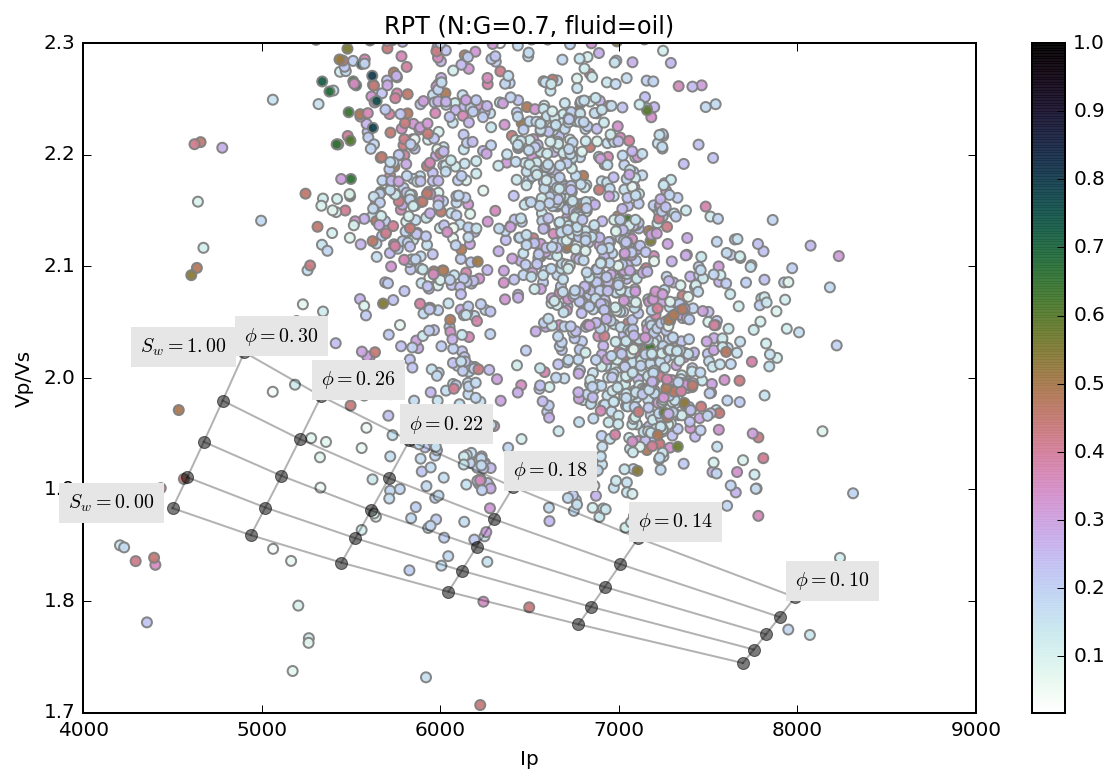

In [10]:
Ksh, Gsh = 12, 4
rpt(model='soft',vsh=0.3,fluid='oil',phic=0.4,Cn=12,P=10)
plt.scatter(ww[:,0],ww[:,1],25,ww[:,2], alpha=0.95, marker='o', edgecolors='.5', cmap='cubehelix_r')
plt.xlim(4000,9000)
plt.ylim(1.7,2.3)
plt.colorbar()

***

Now, this is probably not the best example but I had limited time and only had this log data that I could share publicly; it should be possible to make this data fit with a better combination of model/parameters (after all, this is data used by Avseth et al. in Quantitative Seismic Interpretation -- see also [my other notebooks](https://github.com/aadm/geophysical_notes)).